<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch06/01_main-chapter-code/ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>

# 챕터 6: 텍스트 분류를 위한 미세 튜닝


In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # 그래프 라이브러리
        "numpy",       # 파이토치와 텐서플로의 종속성
        "tiktoken",    # 토크나이저
        "torch",       # 딥러닝 라이브러리
        "tensorflow",  # OpenAI의 사전 훈련된 가중치를 위해서
        "pandas"       # 데이터셋 로딩을 위해
       ]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.0
numpy 버전: 2.0.2
tiktoken 버전: 0.12.0
torch 버전: 2.9.0+cu126
tensorflow 버전: 2.19.0
pandas 버전: 2.2.2


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/01.webp" width=800px>


## 6.1 여러 가지 미세 튜닝 방법


- 이 절에는 코드가 없습니다.


- 가장 일반적인 언어 모델 미세 튜닝 방법은 지시 미세 조정 및 분류 미세 튜닝입니다.
- 아래에 나타난 지시 미세 튜닝은 다음 장의 주제입니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/02.webp" width=700px>


- 이 장의 주제인 분류 미세 튜닝(Classification finetuning)은 머신 러닝에 대한 배경 지식이 있다면 이미 익숙할 수 있는 절차입니다. 예를 들어, 손글씨 숫자를 분류하기 위해 합성곱 신경망을 훈련하는 것과 유사합니다.
- 분류 미세 튜닝에서는 모델이 출력할 수 있는 특정 개수의 클래스 레이블(예: "스팸" 및 "스팸아님")이 있습니다.
- 분류 미세 튜닝된 모델은 훈련 중에 본 클래스(예: "스팸" 또는 "스팸아님")만 예측할 수 있는 반면, 지시 미세 튜닝된 모델은 일반적으로 많은 작업을 수행할 수 있습니다.
- 분류 미세 튜닝된 모델을 매우 특수화된 모델로 생각할 수 있습니다. 실제로는 다양한 작업에서 잘 수행되는 일반 모델보다 특수 모델을 만드는 것이 훨씬 쉽습니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/03.webp" width=600px>


## 6.2 데이터셋 준비


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/04.webp" width=700px>


- 이 섹션에서는 분류 미세 튜닝에 사용할 데이터셋을 준비합니다.
- 스팸 및 스팸아님 텍스트 메시지로 구성된 데이터셋을 분류하기 위해 LLM을 미세 튜닝합니다.
- 먼저 데이터셋을 다운로드하고 압축을 풉니다.


In [2]:
import requests
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path}가 이미 있어 다운로드 및 압축 해제를 건너뜁니다.")
        return

    # 파일을 다운로드 합니다.
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # 파일 압축을 풉니다.
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # .tsv 파일 확장자를 추가합니다.
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"파일이 다운로드되어 {data_file_path}에 저장되었습니다.")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"기본 URL 실패: {e}. 백업 URL을 시도합니다...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


# 책에서는 다음 코드를 사용했지만 VPN을 사용하는 경우 urllib가 문제를 일으킬 수 있습니다.
# 따라서 더 안정적인 `requests` 패키지를 사용합니다.

"""
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path}가 이미 있어 다운로드 및 압축 해제를 건너뜁니다.")
        return

    # 파일을 다운로드 합니다.
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # 파일 압축을 풉니다.
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # .tsv 파일 확장자를 추가합니다.
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"파일이 다운로드되어 {data_file_path}에 저장되었습니다.")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"기본 URL 실패: {e}. 백업 URL을 시도합니다...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
"""

파일이 다운로드되어 sms_spam_collection/SMSSpamCollection.tsv에 저장되었습니다.


'\nimport urllib.request\nimport zipfile\nimport os\nfrom pathlib import Path\n\nurl = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"\nzip_path = "sms_spam_collection.zip"\nextracted_path = "sms_spam_collection"\ndata_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"\n\ndef download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):\n    if data_file_path.exists():\n        print(f"{data_file_path}가 이미 있어 다운로드 및 압축 해제를 건너뜁니다.")\n        return\n\n    # 파일을 다운로드 합니다.\n    with urllib.request.urlopen(url) as response:\n        with open(zip_path, "wb") as out_file:\n            out_file.write(response.read())\n\n    # 파일 압축을 풉니다.\n    with zipfile.ZipFile(zip_path, "r") as zip_ref:\n        zip_ref.extractall(extracted_path)\n\n    # .tsv 파일 확장자를 추가합니다.\n    original_file_path = Path(extracted_path) / "SMSSpamCollection"\n    os.rename(original_file_path, data_file_path)\n    print(f"파일이 다운로드되어 {data_file_path}에 저장되었습니다.")\n\ntry:\n    d

- 데이터셋은 탭으로 구분된 텍스트 파일로 저장되며, 판다스 DataFrame으로 로드할 수 있습니다.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 클래스 분포를 확인해 보면, 데이터에 "스팸"보다 "햄"(즉, "스팸아님")이 훨씬 더 많이 포함되어 있음을 알 수 있습니다.


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 간단하게 하기 위해, 그리고 교육 목적으로 작은 데이터셋을 선호하기 때문에 (LLM을 더 빠르게 미세 튜닝할 수 있음), 각 클래스마다 747개의 샘플이 포함되도록 데이터 세트를 서브샘플링(언더샘플링)합니다.
- (언더샘플링 외에도 클래스 불균형을 처리하는 여러 가지 다른 방법이 있지만 LLM에 관한 책의 범위를 벗어납니다. [`imbalanced-learn` 사용자 가이드](https://imbalanced-learn.org/stable/user_guide.html)에서 예제와 자세한 정보를 찾을 수 있습니다.)


In [5]:
def create_balanced_dataset(df):

    # "스팸" 샘플 개수 세기
    num_spam = df[df["Label"] == "spam"].shape[0]

    # "스팸" 샘플 개수와 일치하도록 "햄" 샘플을 무작위로 샘플링
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # "햄"과 "스팸"을 합침
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 다음으로, 문자열 클래스 레이블 "ham"과 "spam"을 정수 클래스 레이블 0과 1로 변경합니다.


In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [7]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


- 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 무작위 분할하는 함수를 정의해 보겠습니다.


In [8]:
def random_split(df, train_frac, validation_frac):
    # 데이터프레임 전체 섞기
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 분할 인덱스 계산
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # 데이터프레임 분할
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# 테스트 크기는 나머지에 해당하는 0.2입니다.

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 데이터 로더 만들기


- 텍스트 메시지의 길이가 다르다는 점에 유의하세요. 배치에 여러 훈련 샘플을 결합하려면 다음 중 하나를 수행해야 합니다.
  1. 데이터셋 또는 배치에서 가장 짧은 메시지 길이로 모든 메시지를 자릅니다.
  2. 데이터셋 또는 배치에서 가장 긴 메시지 길이로 모든 메시지에 패딩을 추가합니다.

- 옵션 2를 선택하고 데이터셋에서 가장 긴 메시지에 맞춰 모든 메시지에 패딩을 추가합니다.
- 이를 위해 2장에서 설명한 대로 `<|endoftext|>`를 패딩 토큰으로 사용합니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/06.webp" width=800px>


In [9]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- `SpamDataset` 클래스는 학습 데이터셋에서 가장 긴 시퀀스를 식별하고 다른 시퀀스에 패딩 토큰을 추가하여 해당 길이에 맞춥니다.


In [10]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 텍스트 토큰화
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # max_length보다 긴 시퀀스 자르기
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 가장 긴 시퀀스에 맞춰 패딩하기
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length
        # 참고: 이 메서드를 구현하는 더 파이썬적인 버전은
        # 다음과 같으며, 다음 장에서도 사용됩니다.
        # return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [11]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 또한 검증 세트와 테스트 세트를 가장 긴 훈련 시퀀스에 맞춰 패딩합니다.
- 검증 세트와 테스트 세트 샘플 중 가장 긴 훈련 세트 샘플보다 긴 샘플은 `SpamDataset` 코드에서 `encoded_text[:self.max_length]`를 통해 잘린다는 점에 유의하세요.
- 이 동작은 완전히 선택 사항이며, 검증 세트와 테스트 세트의 경우 모두 `max_length=None`으로 설정해도 잘 작동합니다.


In [12]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- 다음으로, 데이터셋을 사용하여 데이터 로더를 만듭니다. 이는 이전 장에서 데이터 로더를 생성하는 것과 유사합니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/07.webp" width=700px>


In [13]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- 검증 단계로서, 데이터 로더를 반복하고 각 배치에 120개의 토큰으로 구성된 8개의 훈련 샘플이 포함되어 있는지 확인합니다.


In [14]:
print("훈련 세트 로더:")
for input_batch, target_batch in train_loader:
    pass

print("입력 배치 차원:", input_batch.shape)
print("레이블 배치 차원", target_batch.shape)

훈련 세트 로더:
입력 배치 차원: torch.Size([8, 120])
레이블 배치 차원 torch.Size([8])


- 마지막으로, 각 데이터셋의 총 배치 수를 출력해 보겠습니다.


In [15]:
print(f"{len(train_loader)}개 훈련 배치")
print(f"{len(val_loader)}개 검증 배치")
print(f"{len(test_loader)}개 테스트 배치")

130개 훈련 배치
19개 검증 배치
38개 테스트 배치


## 6.4 사전 훈련된 가중치로 모델 초기화하기


- 이 섹션에서는 이전 챕터에서 작업했던 사전 훈련된 모델을 초기화합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/08.webp" width=700px>


In [16]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # 어휘사전 크기
    "context_length": 1024,  # 문맥 길이
    "drop_rate": 0.0,        # 드롭아웃 비율
    "qkv_bias": True         # 쿼리-키-값 편향
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"데이터셋 길이 {train_dataset.max_length}가 모델의 문맥 "
    f"길이 {BASE_CONFIG['context_length']}를 초과합니다. `max_length={BASE_CONFIG['context_length']}`로 "
    f"데이터 셋을 다시 초기화하십시오."
)

In [17]:
!wget https://bit.ly/4jZL2Gr -O gpt_download.py
!wget https://bit.ly/4esl8dj -O previous_chapters.py

--2025-11-28 06:51:12--  https://bit.ly/4jZL2Gr
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py [following]
--2025-11-28 06:51:13--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch06/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6333 (6.2K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   6.18K  --.-KB/s    in 0s      

2025-11-28 06:51:13 (87.2 MB/s) - ‘gpt_download.py’ saved [6333/63

In [18]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 139kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.07MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 71.9kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:28<00:00, 5.61MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 8.22MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 644kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 711kiB/s]


- 모델이 제대로 로드되었는지 확인하기 위해 일관된 텍스트를 생성하는지 다시 한번 확인해 보겠습니다.


In [19]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 모델을 분류기로 미세 튜닝하기 전에 프롬프트를 통해 스팸 메시지를 분류할 수 있는지 확인해 보겠습니다.


In [20]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- 보시다시피, 이 모델은 지시 사항을 잘 따르지 못합니다.
- 이는 모델이 사전 학습만 되었고 지시 미세 튜닝되지 않았기 때문에 예상되는 결과입니다 (지시 미세 튜닝은 다음 장에서 다룹니다).


## 6.5 분류 헤드 추가하기


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/09.webp" width=700px>


- 이 절에서는 사전 훈련된 LLM을 분류 미세 튜닝에 사용할 수 있도록 수정합니다.
- 먼저 모델 구조를 살펴보겠습니다.


In [21]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 위에서 4장에서 구현한 구조가 깔끔하게 정리되어 있는 것을 볼 수 있습니다.
- 목표는 출력 층 교체하고 미세 튜닝하는 것입니다.
- 이를 위해 먼저 모델을 동결합니다. 즉, 모든 층을 훈련 불가능하게 만듭니다.


In [22]:
for param in model.parameters():
    param.requires_grad = False

- 그런 다음 출력 층(`model.out_head`)을 교체합니다. 이 층은 입력을 50,257차원(어휘사전 크기)으로 매핑합니다.
- 이진 분류("스팸" 및 "스팸아님"의 두 클래스 예측)를 위해 모델을 미세 튜닝하기 때문에 아래와 같이 출력 층를 교체할 수 있으며 기본적으로 학습 가능합니다.
- 아래 코드를 더 일반적으로 유지하기 위해 `BASE_CONFIG["emb_dim"]`("gpt2-small (124M)" 모델에서 768과 같음)을 사용하는 것에 유의하세요.


In [23]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- 기술적으로 출력 층만 훈련하는 것으로 충분합니다.
- 하지만, [대규모 언어 모델 미세 튜닝](https://magazine.sebastianraschka.com/p/finetuning-large-language-models)에서 확인했듯이, 실험 결과 추가 층을 미세 튜닝하면 성능이 눈에 띄게 향상되는 것으로 나타났습니다.
- 따라서 마지막 트랜스포머 블록과 마지막 트랜스포머 블록을 출력 층에 연결하는 최종 `LayerNorm` 모듈도 훈련 가능하도록 설정합니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/10.webp" width=700px>


In [24]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- 이전 장에서처럼 이 모델을 비슷하게 사용할 수 있습니다.
- 예를 들어, 텍스트 입력을 제공해 보겠습니다.


In [25]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("입력:", inputs)
print("입력 차원:", inputs.shape) # shape: (배치 크기, 토큰 수)

입력: tensor([[5211,  345,  423,  640]])
입력 차원: torch.Size([1, 4])


- 이전 장과 다른 점은 출력 차원이 50,257개가 아니라 2개라는 것입니다.


In [26]:
with torch.no_grad():
    outputs = model(inputs)

print("출력:\n", outputs)
print("출력 차원:", outputs.shape) # shape: (배치 크기, 토큰 수, 클래스 수)

출력:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
출력 차원: torch.Size([1, 4, 2])


- 이전 장에서 논의했듯이 각 입력 토큰에 대해 하나의 출력 벡터가 있습니다.
- 모델에 4개의 입력 토큰이 있는 텍스트 샘플을 제공했으므로 출력은 2차원 출력 벡터 4개로 구성됩니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/11.webp" width=800px>


- 3장에서는 각 입력 토큰을 다른 모든 입력 토큰에 연결하는 어텐션 메커니즘에 대해 논의했습니다.
- 3장에서는 GPT와 같은 모델에 사용되는 코잘 어텐션 마스크도 소개했습니다. 코잘 마스크는 현재 토큰이 현재 및 이전 토큰 위치만 참조하도록 만듭니다.
- 코잘 어텐션 메커니즘을 기반으로, 4번째 (마지막) 토큰이 다른 모든 토큰에 대한 정보를 포함하는 유일한 토큰이기 때문에 모든 토큰 중에서 가장 많은 정보를 담고 있습니다.
- 따라서 우리는 이 마지막 토큰에 특히 관심이 있으며, 스팸 분류 작업을 위해 미세 튜닝할 것입니다.


In [27]:
print("마지막 출력 토큰:", outputs[:, -1, :])

마지막 출력 토큰: tensor([[-3.5983,  3.9902]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/12.webp" width=400px>


## 6.6 분류 손실과 정확도 계산하기


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/13.webp" width=700px>


- 손실 계산을 설명하기 전에 모델 출력이 어떻게 클래스 레이블로 변환되는지 간략하게 살펴보겠습니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/14.webp" width=800px>


In [28]:
print("마지막 출력 토큰:", outputs[:, -1, :])

마지막 출력 토큰: tensor([[-3.5983,  3.9902]])


- 5장과 유사하게, `softmax` 함수를 통해 출력(로짓)을 확률 점수로 변환한 다음 `argmax` 함수를 통해 가장 큰 확률 값의 인덱스를 얻습니다.


In [29]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("클래스 레이블:", label.item())

클래스 레이블: 1


- 5장에서 설명했듯이 소프트맥스 함수는 여기서는 선택 사항입니다. 가장 큰 출력이 가장 큰 확률 점수에 해당하기 때문입니다.


In [30]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("클래스 레이블:", label.item())

클래스 레이블: 1


- 이 개념을 적용하여 소위 분류 정확도를 계산할 수 있습니다. 분류 정확도는 주어진 데이터셋에서 정확하게 예측한 백분율입니다.
- 분류 정확도를 계산하기 위해 앞서 설명한 `argmax` 기반 예측 코드를 데이터셋에 있는 모든 샘플에 적용하고 다음과 같이 정확한 예측의 비율을 계산할 수 있습니다.


In [31]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # 마지막 출력 토큰의 로짓
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- 여러 데이터셋에 대한 분류 정확도를 계산하기 위해 함수를 적용해 보겠습니다.


In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # 파이토치 2.9 이상에서는 mps 결과가 안정적입니다.
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"실행 장치: {device}")

model.to(device) # nn.Module 클래스의 경우 model = model.to(device) 할당문이 필요하지 않습니다.

torch.manual_seed(123) # 데이터 로더에서 셔플링하기 때문에 재현성을 위해

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

실행 장치: cuda
훈련 정확도: 46.25%
검증 정확도: 45.00%
테스트 정확도: 48.75%


- 예상대로 모델을 미세 튜닝하지 않았기 때문에 예측 정확도가 그리 좋지 않습니다.


- 미세 튜닝(훈련)을 시작하기 전에 먼저 훈련 중에 최적화하려는 손실 함수를 정의해야 합니다.
- 목표는 모델의 스팸 분류 정확도를 최대화하는 것이지만 분류 정확도는 미분 가능한 함수가 아닙니다.
- 따라서 분류 정확도를 최대화하는 대신, 크로스 엔트로피 손실을 최소화합니다 (무료 강의 [Introduction to Deep Learning](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression) 8강에서 이 주제에 대해 자세히 알아볼 수 있습니다)

- `calc_loss_batch` 함수는 5장과 동일하지만 모든 토큰 `model(input_batch)` 대신 마지막 토큰 `model(input_batch)[:, -1, :]`을 최적화하는 데에만 관심이 있습니다.


In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 마지막 출력 토큰의 로짓
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

`calc_loss_loader`는 5장과 완전히 동일합니다.


In [34]:
# 5장과 동일
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batches가 데이터 로더의 배치 수를 초과하는 경우
        # 데이터 로더의 총 배치 수와 일치하도록 배치 수를 줄입니다.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- `calc_closs_loader`를 사용하여 훈련을 시작하기 전 초기 훈련, 검증 및 테스트 세트 손실을 계산합니다.


In [35]:
with torch.no_grad(): # 효율성을 위해 그레이디언트 추적을 비활성화합니다. 아직 훈련하지 않기 때문입니다.
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"훈련 손실: {train_loss:.3f}")
print(f"검증 손실: {val_loss:.3f}")
print(f"테스트 손실: {test_loss:.3f}")

훈련 손실: 2.453
검증 손실: 2.583
테스트 손실: 2.322


- 다음 섹션에서는 손실 값과 결과적으로 분류 정확도를 개선하기 위해 모델을 훈련합니다.


## 6.7 지도 학습 데이터로 모델 미세 튜닝하기


- 이 절에서는 모델의 분류 정확도를 향상시키기 위한 훈련 함수를 정의하고 사용합니다.
- 아래 `train_classifier_simple` 함수는 5장에서 모델 사전 훈련에 사용했던 `train_model_simple` 함수와 거의 동일합니다.
- 단 두 가지 차이점은 다음과 같습니다.
  1. 토큰 수 대신 학습된 샘플 수(`examples_seen`)를 추적합니다.
  2. 각 에포크 다음에 샘플 텍스트를 출력하는 대신 정확도를 계산합니다.


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/15.webp" width=600px>


In [36]:
# 5장의 `train_model_simple`과 전체적으로 동일
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # 손실 및 처리한 샘플 수를 위한 리스트 초기화
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # 메인 학습 루프
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치 반복에서 얻은 손실의 그레이디언트 재설정
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실 그레이디언트 계산
            optimizer.step() # 손실 그레이디언트를 사용하여 모델 가중치 업데이트
            examples_seen += input_batch.shape[0] # 새로 추가: 토큰 대신 샘플 추적
            global_step += 1

            # 선택적 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 각 에포크 후 정확도 계산
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"훈련 정확도: {train_accuracy*100:.2f}% | ", end="")
        print(f"검증 정확도: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- `evaluate_model` 함수는 `train_classifier_simple` 에서 사용되며 5장에서 사용한 것과 동일합니다.


In [37]:
# 5장과 동일
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- M3 맥북 에어 노트북 컴퓨터에서는 훈련 시간이 약 5분 정도 소요되며 V100 또는 A100 GPU에서는 30초 미만이 소요됩니다.


In [38]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"훈련 소요 시간: {execution_time_minutes:.2f}분")

에포크 1 (Step 000000): 훈련 손실 2.153, 검증 손실 2.392
에포크 1 (Step 000050): 훈련 손실 0.617, 검증 손실 0.637
에포크 1 (Step 000100): 훈련 손실 0.523, 검증 손실 0.557
훈련 정확도: 70.00% | 검증 정확도: 72.50%
에포크 2 (Step 000150): 훈련 손실 0.561, 검증 손실 0.489
에포크 2 (Step 000200): 훈련 손실 0.419, 검증 손실 0.397
에포크 2 (Step 000250): 훈련 손실 0.409, 검증 손실 0.353
훈련 정확도: 82.50% | 검증 정확도: 85.00%
에포크 3 (Step 000300): 훈련 손실 0.333, 검증 손실 0.320
에포크 3 (Step 000350): 훈련 손실 0.340, 검증 손실 0.306
훈련 정확도: 90.00% | 검증 정확도: 90.00%
에포크 4 (Step 000400): 훈련 손실 0.136, 검증 손실 0.200
에포크 4 (Step 000450): 훈련 손실 0.153, 검증 손실 0.132
에포크 4 (Step 000500): 훈련 손실 0.222, 검증 손실 0.137
훈련 정확도: 100.00% | 검증 정확도: 97.50%
에포크 5 (Step 000550): 훈련 손실 0.207, 검증 손실 0.143
에포크 5 (Step 000600): 훈련 손실 0.083, 검증 손실 0.074
훈련 정확도: 100.00% | 검증 정확도: 97.50%
훈련 소요 시간: 0.98분


- 5장과 유사하게, 맷플롯립을 사용하여 훈련 및 검증 세트에 대한 손실 함수를 그립니다.


In [39]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 훈련 및 검증 손실을 에포크에 따라 그립니다.
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 처리한 샘플 수를 위해 두 번째 x축을 만듭니다.
    ax2 = ax1.twiny()  # 동일한 y축을 공유하는 두 번째 x축을 만듭니다.
    ax2.plot(examples_seen, train_values, alpha=0)  # 눈금 정렬을 위한 보이지 않는 그래프
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 공간을 확보하기 위해 레이아웃을 조정합니다.
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

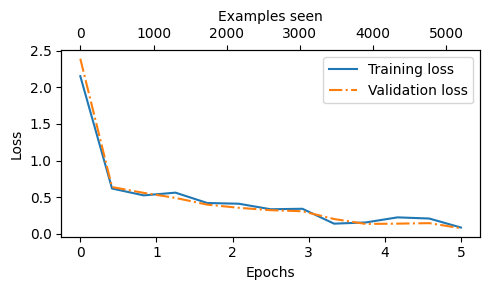

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 기울기가 아래쪽으로 향하고 있으므로 모델이 잘 학습하고 있음을 알 수 있습니다.
- 또한, 훈련 손실과 검증 손실이 매우 가깝다는 사실은 모델이 훈련 데이터에 과대적합되는 경향이 없음을 나타냅니다.
- 마찬가지로, 아래에서 정확도를 그래프로 표시할 수 있습니다.


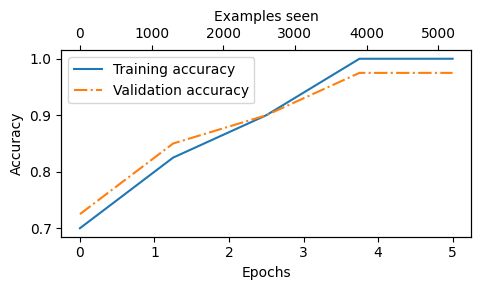

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- 위의 정확도 그래프를 기반으로 에포크 4와 5 이후 모델이 비교적 높은 훈련 및 검증 정확도를 달성했음을 알 수 있습니다.
- 하지만 이전에 훈련 함수에서 `eval_iter=5`를 지정했던 것을 기억해야 합니다. 이는 훈련 및 검증 세트의 일부만 사용해 성능을 추정했음을 의미합니다.
- 아래와 같이 전체 데이터셋에 대한 훈련, 검증 및 테스트 세트 성능을 계산할 수 있습니다.


In [42]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"훈련 정확도: {train_accuracy*100:.2f}%")
print(f"검증 정확도: {val_accuracy*100:.2f}%")
print(f"테스트 정확도: {test_accuracy*100:.2f}%")

훈련 정확도: 97.21%
검증 정확도: 97.32%
테스트 정확도: 95.67%


- 훈련 세트와 검증 세트의 성능이 거의 동일한 것을 확인할 수 있습니다.
- 그러나 테스트 세트 성능이 약간 낮은 것을 보면 모델이 훈련 데이터에 대해 아주 작은 정도로 과적합되었음을 알 수 있으며, 학습률과 같은 일부 하이퍼파라미터를 조정하는 데 사용된 검증 데이터에도 과적합되었음을 알 수 있습니다.
- 하지만 이는 정상적인 현상이며, 모델의 드롭아웃 비율(`drop_rate`)이나 옵티마이저 설정의 `weight_decay`를 높여 이러한 차이를 줄일 수 있습니다.


## 6.8 LLM을 스팸 분류기로 사용하기


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/18.webp" width=700px>


- 마지막으로, 미세 튜닝된 GPT 모델을 실제로 사용해 보겠습니다.
- 아래 `classify_review` 함수는 이전에 구현한 `SpamDataset`과 유사한 데이터 전처리 단계를 구현합니다.
- 그런 다음, 이 함수는 모델에서 예측된 정수 클래스 레이블을 반환하고 해당 클래스 이름을 반환합니다.


In [43]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 모델에 대한 입력 준비
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]

    # 너무 긴 시퀀스 자르기
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length가 지정되지 않았습니다. 모델의 최대 문맥 길이를 사용하려면"
        "max_length=model.pos_emb.weight.shape[0]로 지정하세요."
    )
    assert max_length <= supported_context_length, (
        f"max_length({max_length})가 모델이 지원하는 문맥 길이({supported_context_length})를 초과했습니다."
    )
    # 또는 max_length=None인 경우를 안정적으로 처리하는 방법은 다음과 같습니다.
    # max_len = min(max_length, supported_context_length) if max_length else supported_context_length
    # input_ids = input_ids[:max_len]

    # 가장 긴 시퀀스로 패딩하기
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 배치 차원 추가

    # 모델 추론
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 마지막 출력 토큰의 로짓
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 분류 결과 반환
    return "스팸" if predicted_label == 1 else "스팸아님"

- 몇 개의 샘플로 시험해 보겠습니다.


In [44]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸


In [45]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

스팸아님


- 마지막으로, 나중에 다시 훈련하지 않고 모델을 재사용할 수 있도록 모델을 저장합니다.


In [46]:
torch.save(model.state_dict(), "review_classifier.pth")

- 그런 다음 새 세션에서 다음과 같이 모델을 로드할 수 있습니다.


In [47]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 요약


- 연습 문제 풀이는 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 찾을 수 있습니다.
- 또한 관심 있는 독자는 [부록 E](../../appendix-E)에서 LoRA를 사용한 파라미터 효율적인 훈련에 대한 소개를 찾을 수 있습니다.
